## Importing Libraries

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Hugging Face cache directory
import os
os.environ["HF_HOME"] = "D:/pytorch_project/huggingface_cache"
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Reading Data

In [2]:
df = pd.read_csv('../data/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)

In [3]:
df, _ = train_test_split(df, train_size=10000, stratify=df[0], random_state=42)
df = df.reset_index(drop=True)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,2186835492,Mon Jun 15 19:24:24 PDT 2009,NO_QUERY,AmayaLove,"still sitting under the dryer, my neck hurts"
1,4,2189647623,Tue Jun 16 00:32:41 PDT 2009,NO_QUERY,ronga,@sarahshah this is my nightmare (even tho i on...
2,0,1965889776,Fri May 29 16:43:56 PDT 2009,NO_QUERY,vvvracer,"@mjvarela black is good... tight, or should I ..."
3,0,2056256086,Sat Jun 06 10:48:45 PDT 2009,NO_QUERY,Kayerodriguez,Takes forever for everybody to get ready.
4,0,1564138266,Mon Apr 20 01:58:22 PDT 2009,NO_QUERY,besz,@Bklyncookie omg all the LA bad weather aura i...


In [5]:
df.shape

(10000, 6)

In [6]:
df[0].value_counts().sort_index()

0
0    5000
4    5000
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       10000 non-null  int64 
 1   1       10000 non-null  int64 
 2   2       10000 non-null  object
 3   3       10000 non-null  object
 4   4       10000 non-null  object
 5   5       10000 non-null  object
dtypes: int64(2), object(4)
memory usage: 468.9+ KB


In [8]:
df.describe()

,0,1
count,10000.0000,1.000000e+04
mean,2.0000,2.000397e+09
std,2.0001,1.929987e+08
min,0.0000,1.467824e+09
25%,0.0000,1.956695e+09
50%,2.0000,2.002857e+09
75%,4.0000,2.177858e+09
max,4.0000,2.329145e+09


## Data Preprocessing and Cleaning

In [9]:
df.isna().sum().sum()

np.int64(0)

In [10]:
print(df.columns)

Index([0, 1, 2, 3, 4, 5], dtype='int64')


In [11]:
df[5].iloc[3]

'Takes forever for everybody to get ready. '

In [12]:
df.drop(columns=[1, 2, 3, 4], inplace=True)

In [13]:
df.columns = ['target', 'text']

In [14]:
df.head()

,target,text
0,0,"still sitting under the dryer, my neck hurts"
1,4,@sarahshah this is my nightmare (even tho i on...
2,0,"@mjvarela black is good... tight, or should I ..."
3,0,Takes forever for everybody to get ready.
4,0,@Bklyncookie omg all the LA bad weather aura i...


In [15]:
df['target'].value_counts()

target
0    5000
4    5000
Name: count, dtype: int64

In [16]:
df['target'] = df['target'].map({0: 0, 4: 1})
df['target'].value_counts()

target
0    5000
1    5000
Name: count, dtype: int64

## Clean text function

In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)        # Remove mentions and hashtags
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra whitespaces
    return text

In [18]:
df['text'] = df['text'].apply(clean_text)

In [19]:
df['text'][3]

'Takes forever for everybody to get ready.'

In [20]:
df.head()

,target,text
0,0,"still sitting under the dryer, my neck hurts"
1,1,this is my nightmare (even tho i only have 3 p...
2,0,"black is good... tight, or should I say too ti..."
3,0,Takes forever for everybody to get ready.
4,0,omg all the LA bad weather aura is trickling i...


In [21]:
X = df.drop('target', axis=1)
y = df['target']

## Train/validation/test split

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

## Load tokenizer

In [23]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Define custom dataset

In [24]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [25]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Create datasets and dataloaders

In [26]:
train_dataset = SentimentDataset(X_train['text'], y_train.tolist(), tokenizer)
val_dataset = SentimentDataset(X_val['text'], y_val.tolist(), tokenizer)
test_dataset = SentimentDataset(X_test['text'], y_test.tolist(), tokenizer)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Load model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.000002)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training and validation loop

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 1
counter = 0
best_model_path = '../my_model/'

epochs = 7
    
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    total_steps = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{epochs}")

    for step, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Training Progress (per batch)
        if (step + 1) % 20 == 0 or (step + 1) == total_steps:
            print(f"[{step + 1}/{total_steps}] Batch Loss: {loss.item():.4f} | Running Accuracy: {correct / total:.4f}")

         # Train metrics for epoch
    avg_train_loss = total_loss / total_steps
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0


    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"\n[Epoch {epoch + 1}] Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"[Epoch {epoch + 1}] Val   Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Saving the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(best_model_path)
        print(f"✅ Model saved (val_loss improved to {best_val_loss:.4f})")
        counter = 0
    else:
        counter += 1
        print(f"⏳ No improvement in val_loss for {counter} epoch(s)")

        if counter >= patience:
            print(f"⛔ Early stopping triggered after {patience} epochs without improvement.")
            break


Epoch 1/7
[20/188] Batch Loss: 0.6935 | Running Accuracy: 0.4734
[40/188] Batch Loss: 0.6884 | Running Accuracy: 0.4695
[60/188] Batch Loss: 0.6934 | Running Accuracy: 0.4781
[80/188] Batch Loss: 0.7043 | Running Accuracy: 0.4961
[100/188] Batch Loss: 0.6930 | Running Accuracy: 0.5175
[120/188] Batch Loss: 0.6670 | Running Accuracy: 0.5292
[140/188] Batch Loss: 0.6587 | Running Accuracy: 0.5446
[160/188] Batch Loss: 0.6872 | Running Accuracy: 0.5541
[180/188] Batch Loss: 0.6827 | Running Accuracy: 0.5639
[188/188] Batch Loss: 0.6439 | Running Accuracy: 0.5680

[Epoch 1] Train Loss: 0.6842, Accuracy: 0.5680
[Epoch 1] Val   Loss: 0.6469, Accuracy: 0.7175
✅ Model saved (val_loss improved to 0.6469)

Epoch 2/7
[20/188] Batch Loss: 0.6387 | Running Accuracy: 0.6672
[40/188] Batch Loss: 0.6243 | Running Accuracy: 0.6922
[60/188] Batch Loss: 0.5598 | Running Accuracy: 0.7063
[80/188] Batch Loss: 0.5983 | Running Accuracy: 0.7148
[100/188] Batch Loss: 0.5365 | Running Accuracy: 0.7225
[120/18

## 📈 Model Performance during Training

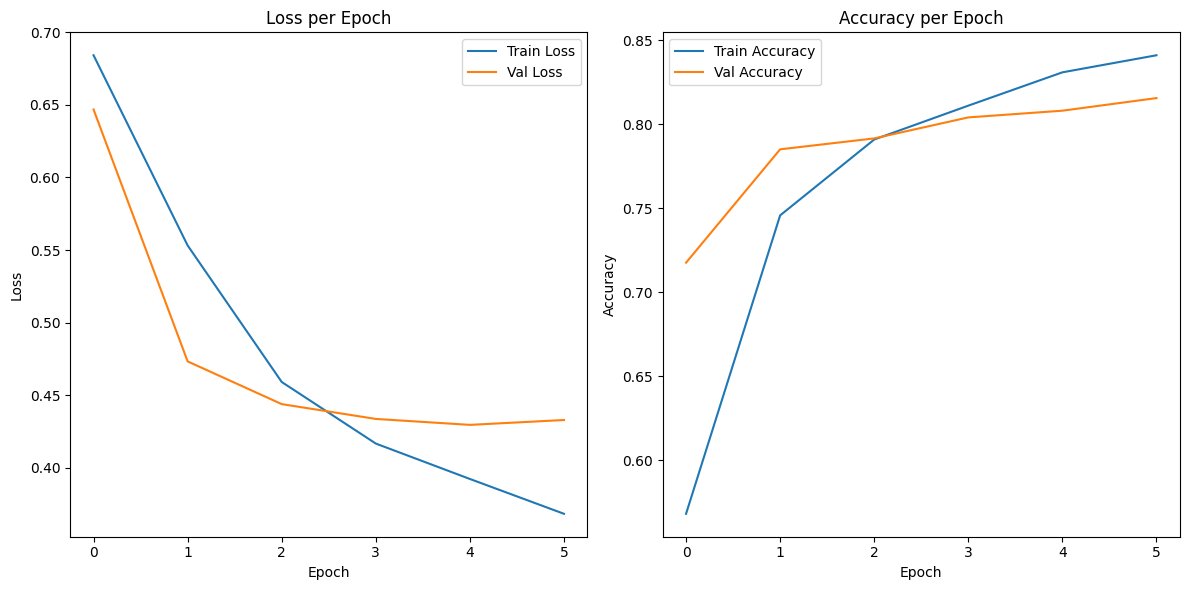

In [31]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []
all_probs = []

# Load the best model before testing
model.load_state_dict(torch.load(best_model_path))
model.eval()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total

precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
roc_auc = roc_auc_score(all_labels, all_probs)


print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")


Test Loss: 0.4315
Test Accuracy: 0.8045
Precision: 0.8024
Recall:    0.8080
F1 Score:  0.8052
ROC AUC:   0.8837


## Confusion Matrix

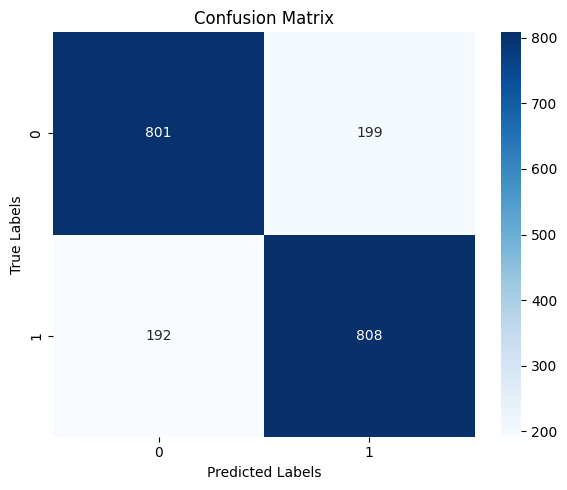

In [33]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [34]:
def predict_sentiment(text):
    model.eval()


    def clean_text(text):
        text = re.sub(r"http\S+|www\S+", '', text)
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    cleaned_text = clean_text(text)


    inputs = tokenizer(cleaned_text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}


    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = F.softmax(logits, dim=1)[0][predicted_class].item()

    label = "Positive 😊" if predicted_class == 1 else "Negative 😠"
    return label, confidence

In [35]:
text = "on this week i'll cook cake"
label, conf = predict_sentiment(text)
print(f"Prediction: {label} (Confidence: {conf:.2f})")

Prediction: Positive 😊 (Confidence: 0.93)
